# Reaching the Confusion Limit

Some of the science from Galactic Plane fields requires us to reach the confusion limit in the deep co-added images in all filters.  Examples include the discovery of all Star Forming Regions, galactic star clusters and Local Volumn Dwarf Galaxies.  

The confusion limit varies across the sky due to crowding, particularly in the Galactic Plane.  
How many visits are required to reach this limit as a function of position on sky and filter?

For the purposes of this investigation, we define the crowding limit to be an average of 1 star per LSSTCam pixel, which has a spatial resolution of 0.2 arcsec/pixel. 

In [1]:
from os import path
import rubin_sim.maf as maf
from rubin_sim.data import get_data_dir
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy.io import fits

The MAF offers a metric, fiveSigmaDepth, which calculates the limiting magnitude reached to a 5-sigma detection level in the coadded images over the whole survey.  This is calculated for each filter, using the Baseline_v2.0 OpSim.

In [2]:
opsim_db_file = '/Users/rstreet1/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db'
opsim_db = maf.OpsimDatabase(opsim_db_file)
runName = path.split(opsim_db_file)[-1].replace('.db', '')

In [39]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
PIXAREA = hp.nside2pixarea(NSIDE,degrees=True)

metricData = {}
for f in ["u","g","r","i","z","y"]:
    bundleList = []
    metric1 = maf.metrics.simpleMetrics.Coaddm5Metric()
    constraint = 'filter = "'+f+'"'
    slicer = maf.slicers.HealpixSlicer(nside=NSIDE, useCache=False)
    plotDict = {'colorMax': 950}
    bundleList.append(maf.MetricBundle(metric1, slicer, constraint, runName=runName, plotDict=plotDict))
    bundleDict = maf.metricBundles.makeBundlesDictFromList(bundleList)
    bundleGroup = maf.MetricBundleGroup(bundleDict, opsim_db, outDir='test', resultsDb=None)
    bundleGroup.runAll()

    outputName = 'baseline_v2_0_10yrs_CoaddM5_'+f+'_HEAL'
    metricData[f] = bundleDict[outputName].metricValues.filled(0.0)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with constraint filter = "u" for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 134566 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with constraint filter = "g" for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 217817 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with constraint filter = "r" for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 464851 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_r_HEAL']
Completed metric generation.
Running

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_11704/3267893736.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


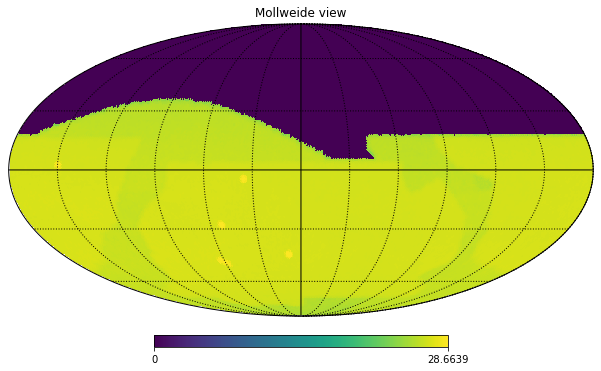

In [30]:
fig = plt.figure(1,(10,10))
hp.mollview(metricData['r'])
hp.graticule()
plt.tight_layout()
plt.close(1)

This gives us the limiting magnitude reached for each HEALpixel on the sky in each filter.  We can compare this with maps of the stellar density as a function of position.  The function below uses maps from the TriLegal galactic model, and allows selection of sample by limiting magnitude.

In [32]:
def load_star_density_data(limiting_mag=28.0):

    data_file = '/Users/rstreet1/rubin_sim_data/maps/TriMaps/TRIstarDensity_r_nside_64_ext.npz'
    if path.isfile(data_file):
        npz_file = np.load(data_file)
        with np.load(data_file) as npz_file:
            star_map = npz_file['starDensity']
            mag_bins = npz_file['bins']

            dmag = abs(mag_bins - limiting_mag)
            idx = np.where(dmag == dmag.min())[0]

            star_density_map = np.copy(star_map[:,idx]).flatten()
            star_density_map = hp.reorder(star_density_map, n2r=True)

        return star_density_map

    else:
        raise IOError('Cannot find star density map data file at '+data_file)

    return None

The initial orientation of this dataset doesn't match that of the HEALpixel data used by the MAF so we re-order the array.

In [36]:
def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    """Rotates healpix map from one system to the other. Returns reordered healpy map.
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2.
    Original code by Xiaolong Li
    """

    # For reasons I don't understand, entering in ['C', 'G'] seems to do the
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.

    # Heavily influenced by stack overflow solution here:
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy

    nside = hp.npix2nside(len(hpmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)

    return rot_map

The stellar density data is provided per HEALpixel, which has an area around 1 sq.deg.  To compare this with LSSTCam's spatial resolution, we scale up the number of stars that would have to be in the area of 1 HEALpixel for LSSTCam to be at the confusion limit. However, a stellar PSF typically requires a radius of ~4 pixels to avoid being under-sampled.  We therefore consider LSST PSF area here rather than the pixel resolution.

In [51]:
HPAREA = hp.nside2pixarea(NSIDE,degrees=True)
LSSTpixelScale = 0.2/3600.0
psfRadius = 4.0
LSSTPSFArea = np.pi*(psfRadius*LSSTpixelScale)**2
max_stellar_density = HPAREA/LSSTPSFArea
print('Area of HEALpixel = '+str(HPAREA)+'sq deg')
print('Area of LSST PSF = '+str(LSSTPSFArea)+'sq deg')
print('Maximum stellar density at confusion limit: '+str(max_stellar_density)+' stars / sq deg.')

Area of HEALpixel = 0.8392936452111668sq deg
Area of LSST PSF = 1.5514037795505153e-07sq deg
Maximum stellar density at confusion limit: 5409898.159809392 stars / sq deg.


Range in limiting magnitudes for u: 22.535686805713887 to 27.53458434948871
30442 survey pixels are within this range of limiting magnitude
31 survey pixels in with this lmag are confusion limited
30442 survey pixels are within this range of limiting magnitude
31 survey pixels in with this lmag are confusion limited
30442 survey pixels are within this range of limiting magnitude
44 survey pixels in with this lmag are confusion limited
30442 survey pixels are within this range of limiting magnitude
44 survey pixels in with this lmag are confusion limited
30442 survey pixels are within this range of limiting magnitude
51 survey pixels in with this lmag are confusion limited
30442 survey pixels are within this range of limiting magnitude
51 survey pixels in with this lmag are confusion limited
30442 survey pixels are within this range of limiting magnitude
56 survey pixels in with this lmag are confusion limited
30442 survey pixels are within this range of limiting magnitude
56 survey pix

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_11704/2995001172.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Range in limiting magnitudes for g: 22.944524236852445 to 28.721743728794454
33613 survey pixels are within this range of limiting magnitude
51 survey pixels in with this lmag are confusion limited
33613 survey pixels are within this range of limiting magnitude
51 survey pixels in with this lmag are confusion limited
33613 survey pixels are within this range of limiting magnitude
56 survey pixels in with this lmag are confusion limited
33613 survey pixels are within this range of limiting magnitude
56 survey pixels in with this lmag are confusion limited
33613 survey pixels are within this range of limiting magnitude
67 survey pixels in with this lmag are confusion limited
33613 survey pixels are within this range of limiting magnitude
67 survey pixels in with this lmag are confusion limited
33613 survey pixels are within this range of limiting magnitude
86 survey pixels in with this lmag are confusion limited
33613 survey pixels are within this range of limiting magnitude
86 survey pi

0.0 180.0 -180.0 180.0


Range in limiting magnitudes for r: 22.424726156674502 to 28.663863584873113
33659 survey pixels are within this range of limiting magnitude
21 survey pixels in with this lmag are confusion limited
33659 survey pixels are within this range of limiting magnitude
31 survey pixels in with this lmag are confusion limited
33659 survey pixels are within this range of limiting magnitude
31 survey pixels in with this lmag are confusion limited
33659 survey pixels are within this range of limiting magnitude
44 survey pixels in with this lmag are confusion limited
33659 survey pixels are within this range of limiting magnitude
44 survey pixels in with this lmag are confusion limited
33659 survey pixels are within this range of limiting magnitude
51 survey pixels in with this lmag are confusion limited
33659 survey pixels are within this range of limiting magnitude
51 survey pixels in with this lmag are confusion limited
33659 survey pixels are within this range of limiting magnitude
56 survey pi

0.0 180.0 -180.0 180.0


Range in limiting magnitudes for i: 21.77522275196703 to 28.22175971779111
33666 survey pixels are within this range of limiting magnitude
8 survey pixels in with this lmag are confusion limited
33666 survey pixels are within this range of limiting magnitude
8 survey pixels in with this lmag are confusion limited
33666 survey pixels are within this range of limiting magnitude
11 survey pixels in with this lmag are confusion limited
33666 survey pixels are within this range of limiting magnitude
11 survey pixels in with this lmag are confusion limited
33666 survey pixels are within this range of limiting magnitude
14 survey pixels in with this lmag are confusion limited
33666 survey pixels are within this range of limiting magnitude
14 survey pixels in with this lmag are confusion limited
33666 survey pixels are within this range of limiting magnitude
21 survey pixels in with this lmag are confusion limited
33666 survey pixels are within this range of limiting magnitude
21 survey pixels

0.0 180.0 -180.0 180.0


Range in limiting magnitudes for z: 21.397630950427853 to 27.263576587955253
33647 survey pixels are within this range of limiting magnitude
2 survey pixels in with this lmag are confusion limited
33647 survey pixels are within this range of limiting magnitude
2 survey pixels in with this lmag are confusion limited
33647 survey pixels are within this range of limiting magnitude
3 survey pixels in with this lmag are confusion limited
33647 survey pixels are within this range of limiting magnitude
3 survey pixels in with this lmag are confusion limited
33647 survey pixels are within this range of limiting magnitude
8 survey pixels in with this lmag are confusion limited
33647 survey pixels are within this range of limiting magnitude
8 survey pixels in with this lmag are confusion limited
33647 survey pixels are within this range of limiting magnitude
11 survey pixels in with this lmag are confusion limited
33647 survey pixels are within this range of limiting magnitude
11 survey pixels i

0.0 180.0 -180.0 180.0


Range in limiting magnitudes for y: 20.7511364735339 to 26.793245077222384
30506 survey pixels are within this range of limiting magnitude
0 survey pixels in with this lmag are confusion limited
30506 survey pixels are within this range of limiting magnitude
0 survey pixels in with this lmag are confusion limited
30506 survey pixels are within this range of limiting magnitude
0 survey pixels in with this lmag are confusion limited
30506 survey pixels are within this range of limiting magnitude
0 survey pixels in with this lmag are confusion limited
30506 survey pixels are within this range of limiting magnitude
0 survey pixels in with this lmag are confusion limited
30506 survey pixels are within this range of limiting magnitude
0 survey pixels in with this lmag are confusion limited
30506 survey pixels are within this range of limiting magnitude
2 survey pixels in with this lmag are confusion limited
30506 survey pixels are within this range of limiting magnitude
2 survey pixels in wi

0.0 180.0 -180.0 180.0


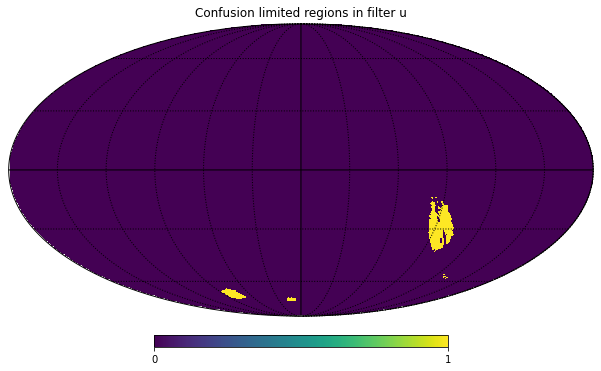

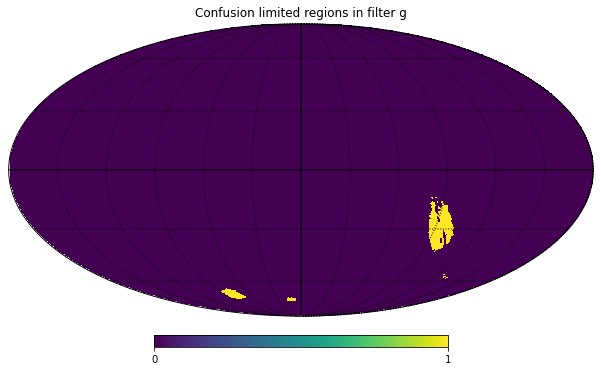

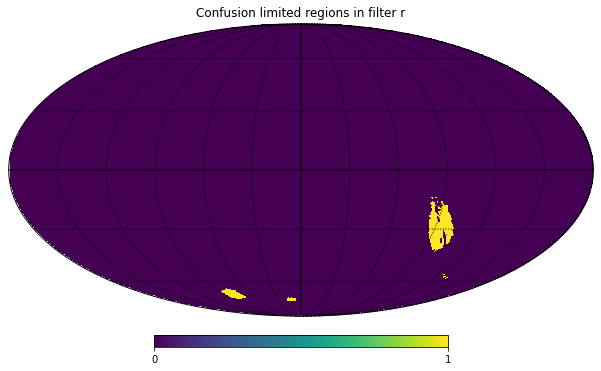

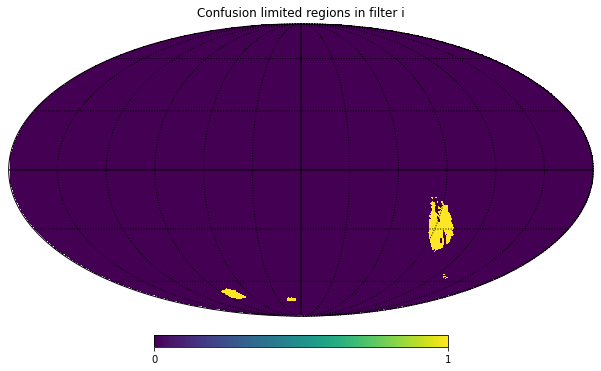

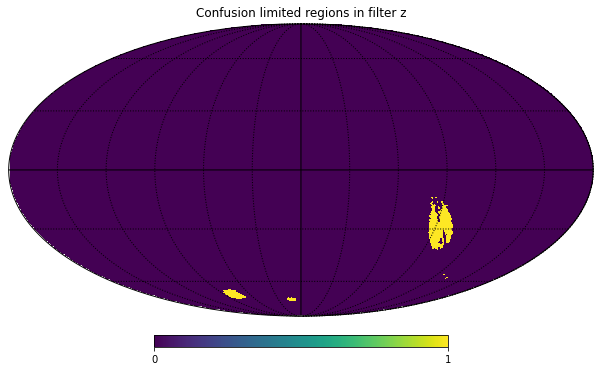

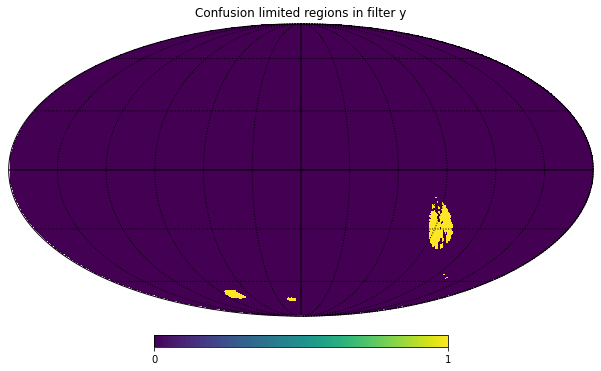

In [66]:
lmag_step = 0.1
for f in ['u','g','r','i','z','y']:
    result_map = np.zeros(NPIX)
    limiting_mag_data = metricData[f]
    vis_pixels = np.where(limiting_mag_data > 0.0)[0]
    
    lmag_min = limiting_mag_data[vis_pixels].min()
    lmag_max = limiting_mag_data[vis_pixels].max()
    print('Range in limiting magnitudes for '+f+': '+str(lmag_min)+' to '+str(lmag_max))
    for lmag in np.arange(lmag_min, lmag_max, lmag_step):
        idx1 = np.where(metricData[f] >= lmag_min)[0]
        idx2 = np.where(metricData[f] <= lmag_max)[0]
        lmag_pixels = list(set(idx1).intersection(set(idx2)))
        print(str(len(lmag_pixels))+' survey pixels are within this range of limiting magnitude')
        
        try:
            star_density_map = load_star_density_data(limiting_mag=lmag)
            star_density_map = rotateHealpix(star_density_map)

            conf_pixels = np.where(star_density_map >= max_stellar_density)[0]
            
            conf_survey_pixels = list(set(conf_pixels).intersection(set(lmag_pixels)))
            print(str(len(conf_survey_pixels))+' survey pixels in with this lmag are confusion limited')
            
            if len(conf_pixels) > 0:
                metricData[f][conf_pixels]
                result_map[conf_survey_pixels] = 1.0
        except IndexError:
            pass
    
    fig = plt.figure(2,(10,10))
    hp.mollview(result_map, title="Confusion limited regions in filter "+f)
    hp.graticule()
    plt.tight_layout()
    plt.close(2)

The analysis above implies that LSST will only be confusion limited for restricted regions in the central Galactic Bulge and Plane and the Magellenic Clouds.  

In all other areas of the sky, the confusion limit isn't the primary restriction on the faintest magnitude reached - number of visits is. 

So how can we evaluate whether we have "sufficient" visits to all fields across the Galactic Plane?  And what is the minimum number of visits required to reach a "sufficient" limiting magnitude?

Well the stated limiting magnitude goals for coadded frames of LSST after 10yrs are (stationary targets) [https://www.lsst.org/scientists/keynumbers]:

In [67]:
lmag_goals = {'u': 26.1, 'g': 27.4, 'r': 27.5, 'i': 26.8, 'z': 26.1, 'y': 24.9}

Does the baseline_v2.0 reach these limits?

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_11704/2295736329.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


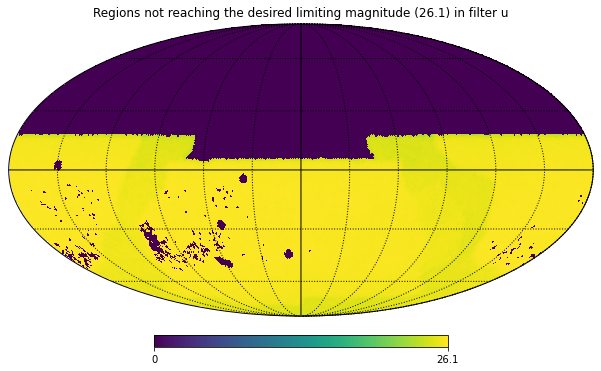

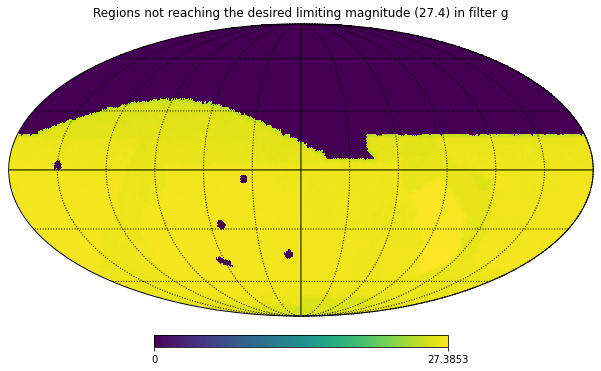

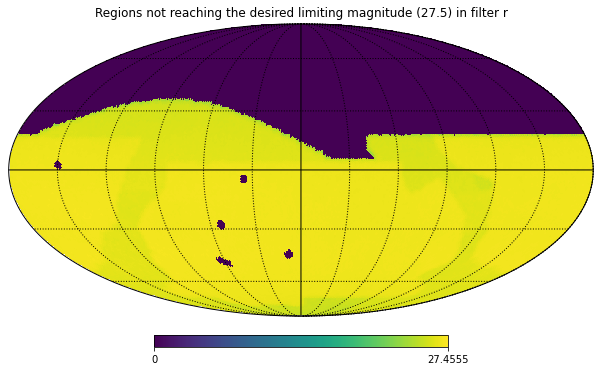

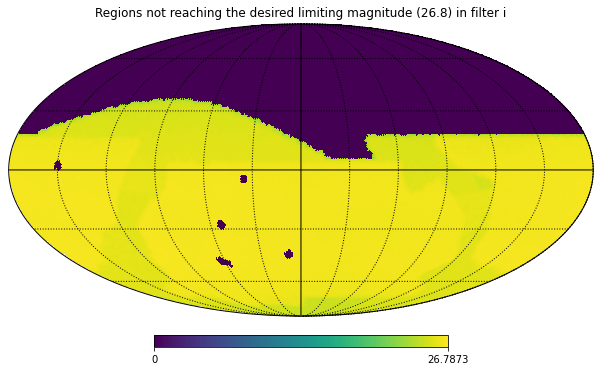

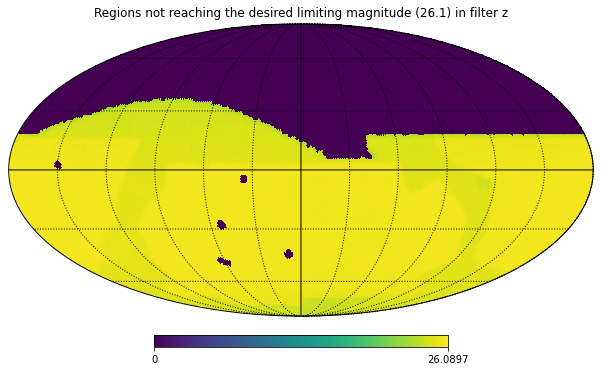

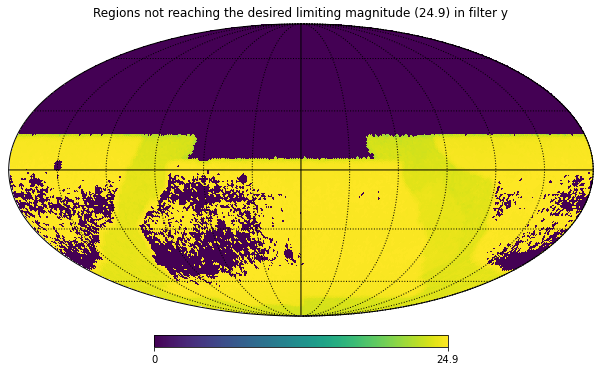

In [72]:
for f in ['u','g','r','i','z','y']:
    idx = np.where(metricData[f] < lmag_goals[f])[0]
    map_data = np.zeros(NPIX)
    map_data[idx] = metricData[f][idx]
    fig = plt.figure(3,(10,10))
    hp.mollview(map_data, title="Regions not reaching the desired limiting magnitude ("+str(lmag_goals[f])+") in filter "+f)
    hp.graticule()
    plt.tight_layout()
    plt.close(3)

So in practice, the only regions reaching these co-add limits are the deep drilling fields. 

The Prisinzano et al 2018 cadence White Paper describes a requirement for "WFD-like cadence across the Galactic Plane", in order to detect the fainter members of star clusters and Star Forming Regions.  
That would imply >700 visits per HEALpixel.  They cite the following limiting magnitude goals:

In [73]:
lmag_goals = {'g': 27.5, 'r': 27.7, 'i': 27.0}

These numbers were drawn from the LSST Science Book, v2.0 but give limits that are fainter than those currently anticipated from the main WFD science requirements, so this is infeasible. 

Instead, I experiment here with some plausible limits for a volume-limited survey.

0.0 180.0 -180.0 180.0
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_11704/508356856.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


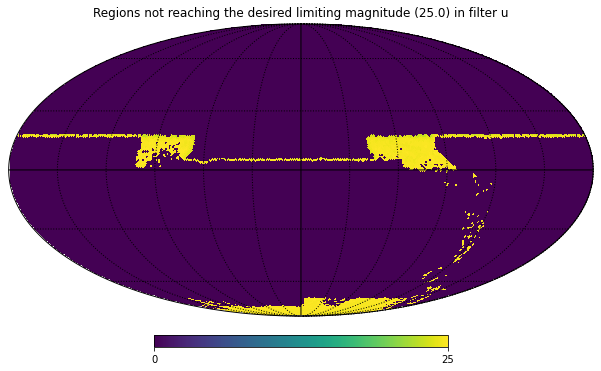

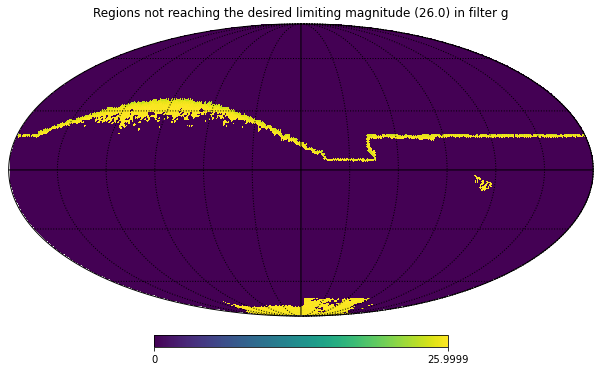

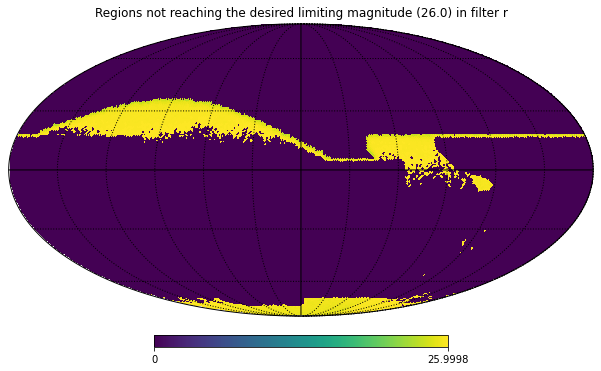

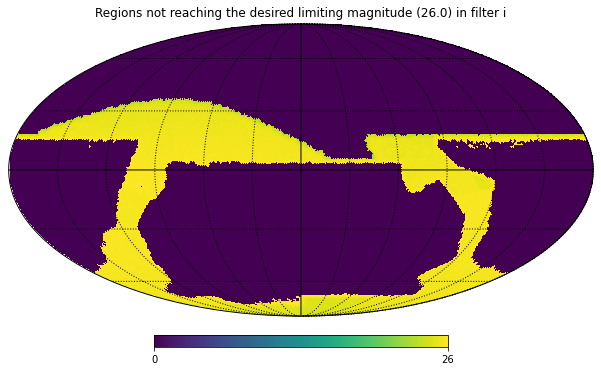

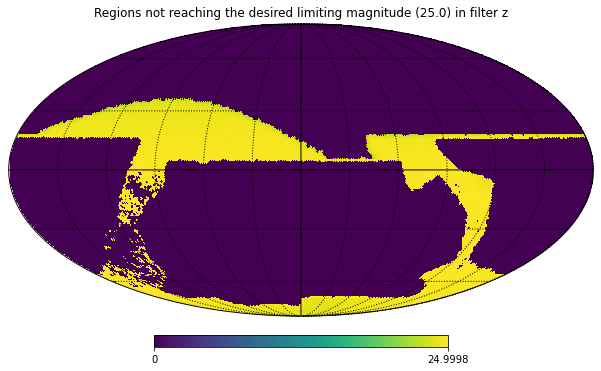

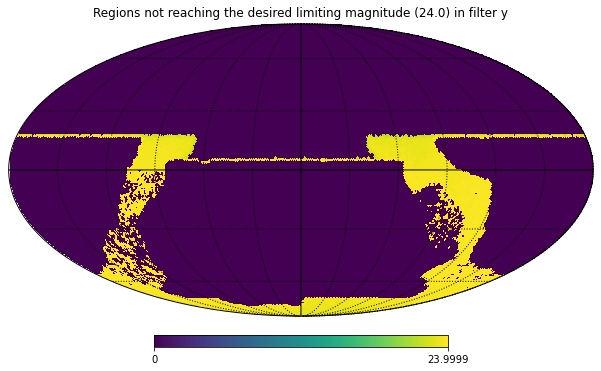

In [74]:
lmag_goals = {'u': 25.0, 'g': 26.0, 'r': 26.0, 'i': 26.0, 'z': 25.0, 'y': 24.0}
for f in ['u','g','r','i','z','y']:
    idx = np.where(metricData[f] < lmag_goals[f])[0]
    map_data = np.zeros(NPIX)
    map_data[idx] = metricData[f][idx]
    fig = plt.figure(3,(10,10))
    hp.mollview(map_data, title="Regions not reaching the desired limiting magnitude ("+str(lmag_goals[f])+") in filter "+f)
    hp.graticule()
    plt.tight_layout()
    plt.close(3)

One possible strategy could be to restrict the number of filters covered at high cadence.  

In [78]:
s = SkyCoord('17:45:36', '-23:27:40', frame='icrs', unit=(u.hourangle, u.deg))
sg = s.transform_to(Galactic)
sg

<SkyCoord (Galactic): (l, b) in deg
    (4.67466176, 2.85341714)>